This script is to check meridional projection. 

In [2]:
import sys
import numpy as np
import pandas as pd  
import xarray as xr 
import dask
from scipy import special
import math 
import matplotlib.pyplot as plt 

In [6]:
import sys
import numpy as np
import pandas as pd  
import xarray as xr 
import dask
from scipy import special
import math 
import matplotlib.pyplot as plt 

def projection(vn, zmode=1, m=1, mflg='off', wnx=10, wnxflg='all', time_range=['1979-01-01','2019-12-31'], lat_range=[90, -90]):
    # zmode: the vertical mode, default m = 1
    # m: wave truncation
    # wnx: zonal wave number truncation [inclusive]
    # time_range: the time range of the data used in training and validating the model [inclusive]
    # lat_range: the latitude range (y) of the data used in projection

    # read data; any file with olr[time, lat, lon]
    fn = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/ERA5.'+vn+'GfltG.day.1901to2020.nc'
    ds = xr.open_dataset(fn)

    ds1 = ds.sel(time=slice(time_range[0], time_range[1]), lat=slice(lat_range[0], lat_range[1]))

    olr = ds1[vn].values  # (time, lat, lon)
    lat = ds1['lat']
    lon = ds1['lon'].values
    time = ds1['time'].values

    if mflg=='off':
        olr_re = np.copy(olr)  # no dimension reduction on the meridional direction. 
    else:  
        # parameters
        N = 1e-2  # buoyancy frequency (s-1)
        H = 1.6e4  # tropopause height (m)
        beta= 2.28e-11  # variation of coriolis parameter with latitude
        g = 9.8  # gravity acceleration 
        theta0 = 300  # surface potential temperature (K)
        c = N * H / np.pi / zmode # gravity wave speed
        L = np.sqrt(c / beta)  # horizontal scale (m)
    


        # define y = lat * 110 km / L
        y = lat.values * 110 * 1000 / L # dimensionless

        # define meridianol wave structures
        phi = []

        # define which equatorial wave is included in the reconstructed map
        # m is analogous to a meridional wavenumber
        # m = 0: mostly Kelvin wave
        # m = 2: mostly Rossby wave

        if mflg=='odd':
            m_list = np.arange(1,m,2)  
        elif mflg=='even':
            m_list = np.arange(0,m,2)
        elif mflg=='all':
            m_list = np.arange(m)
        elif mflg=='one':
            m_list = [m-1]
        elif mflg=='1pls':
            m_list = [0,m-1]
        elif mflg=='no1':
            m_list = np.arange(1,m)
        elif mflg=='resi':
            m_list = np.arange(m)  # this is the part to be removed from filtered map
        else:
            print('wrong m flag!')
            exit()

        for i in m_list:
            p = special.hermite(i)
            Hm = p(y)
            phim = np.exp(- y**2 / 2) * Hm / np.sqrt((2**i) * np.sqrt(np.pi) * math.factorial(i))

            phi.append(np.reshape(phim, (1, len(y), 1)))

        # projection coefficients
        olrm = []

        dy = (lat[0].values - lat[1].values) * 110 * 1000 / L 

        for i in range(len(m_list)):
            um = np.sum(olr * phi[i] * dy, axis=1, keepdims=True)  # (time, 1, lon)
            olrm.append(um)

        # reconstruction 
        olr_re = np.zeros(np.shape(olr))  # (time, lat, lon)

        for i in range(len(m_list)):
            olr_re = olr_re + olrm[i] * phi[i]
        
        if mflg=='resi':
            olr_re1 = olr - olr_re
            del olr_re
            olr_re = np.copy(olr_re1)
            del olr_re1

    if wnxflg=='off':
        olr_re_fft = np.copy(olr_re)
    else:
        # do fourier transform along each latitude at each time step
        coef_fft = np.fft.rfft(olr_re, axis=2)
        # remove waves whose zonal wave cycles are larger than wnx
        if wnxflg=='all':
            coef_fft[:,:,wnx+1:] = 0.0 
        elif wnxflg=='one':
            coef_fft[:,:,:wnx] = 0.0
            coef_fft[:,:,wnx+1:] = 0.0 
        elif wnxflg=='no0':  # include 1, 2, ..., wnx
            coef_fft[:,:,wnx+1:] = 0.0 
            coef_fft[:,:,0] = 0.0
        elif wnxflg=='no0p7': # include 1, 2, ..., wnx, 7
            coef_fft[:,:,wnx+1:7] = 0.0 
            coef_fft[:,:,8:] = 0.0 
            coef_fft[:,:,0] = 0.0
        elif wnxflg=='resi':  # resi of 0-wnx[inclusive]
             coef_fft[:,:,:wnx+1] = 0.0
        else:
            print('wrong wnx flag!')
            exit()
        # reconstruct OLR with selected zonal waves
        olr_re_fft = np.fft.irfft(coef_fft, np.shape(olr_re)[2], axis=2)

    # # save the OLR maps at the first time step
    # fig, ax = plt.subplots(2,2)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)

    # # fig1: filtered OLR
    # im = ax[0,0].contourf(olr[0,:,:])
    # plt.colorbar(im, ax=ax[0,0])
    # ax[0,0].set_title('filtered')

    # # fig2: reconstructed OLR after projection
    # im = ax[0,1].contourf(olr_re[0,:,:])
    # plt.colorbar(im, ax=ax[0,1])
    # ax[0,1].set_title('filtered+Yproj_m'+str(m)+mflg)

    # # fig3: reconstructed OLR after zonal fft
    # im = ax[1,0].contourf(olr_re_fft[0,:,:])
    # plt.colorbar(im, ax=ax[1,0])
    # ax[1,0].set_title('filtered+Yproj_m'+str(m)+mflg+'_wnx'+str(wnx)+wnxflg)

    # # fig4: reconstructed OLR after zonal fft - filtered OLR
    # tmp = olr_re_fft[0,:,:] - olr[0,:,:]
    # im = ax[1,1].contourf(tmp)
    # plt.colorbar(im, ax=ax[1,1])
    # ax[1,1].set_title('Diff: 3 - 1')

    # save the OLR maps at the first time step
    fig, ax = plt.subplots(2,1)
    fig.set_figheight(6)
    fig.set_figwidth(12)

    # fig1: reconstructed OLR after zonal fft
    im = ax[0].contourf(lon, lat.values, olr_re_fft[0,:,:])
    ax[0].set_xlabel('longitude')
    ax[0].set_ylabel('latitude')
    plt.colorbar(im, ax=ax[0])
    ax[0].set_title('filtered+Yproj_m'+str(m)+mflg+'_wnx'+str(wnx)+wnxflg)

    # fig2: filtered OLR - reconstructed OLR after zonal fft
    tmp = olr[0,:,:] - olr_re_fft[0,:,:] 
    im = ax[1].contourf(lon, lat.values, tmp)
    ax[1].set_xlabel('longitude')
    ax[1].set_ylabel('latitude')
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title('information missing from the filtered map')

    plt.subplots_adjust(hspace=0.4)

    # fig.savefig('./output/'+vn+'_m'+str(m)+mflg+'_wnx'+str(wnx)+wnxflg+'.jpg')

    return olr_re_fft  # (time, lat, lon)



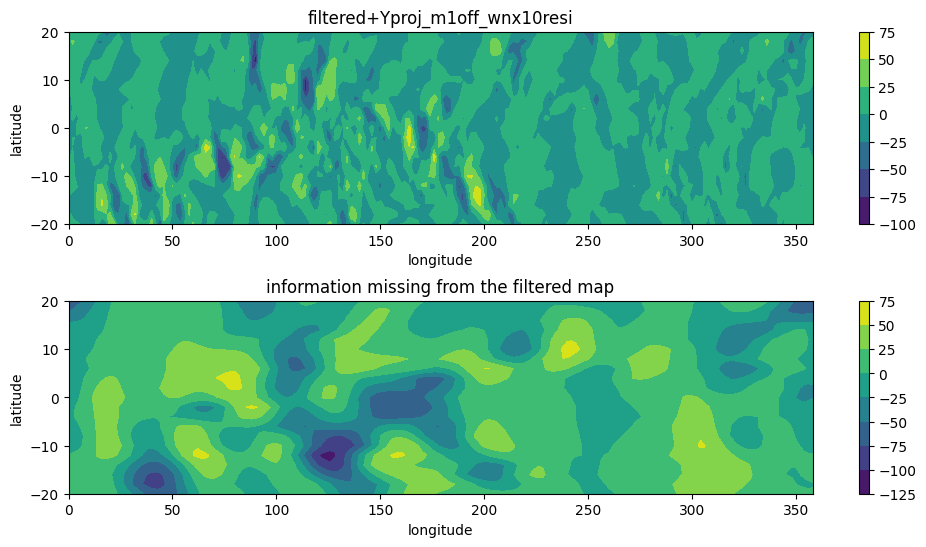

In [17]:
olr = projection('olr',m=1, mflg='off', wnx=10, wnxflg='resi', time_range=['2015-01-01','2015-01-02'], lat_range=[20,-20])

Text(0.5, 1.0, 'reduced reconstruct - raw')

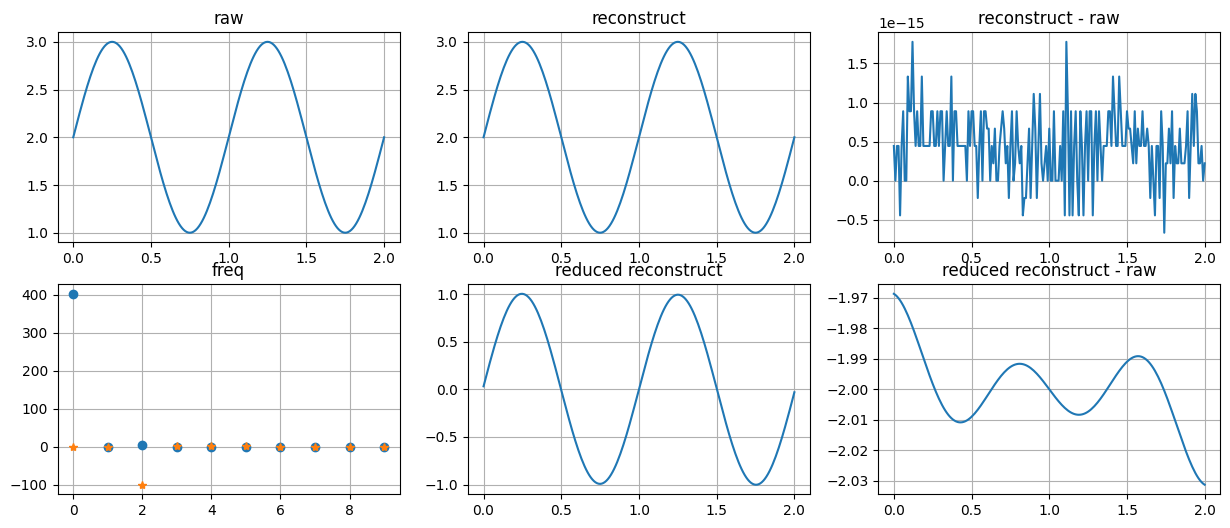

In [4]:
# fig,ax = plt.subplots(2,3)
# fig.set_figheight(6)
# fig.set_figwidth(15)


# x = np.arange(201)  / 100
# olr_re = np.sin(x * 2 * np.pi) +2
# ax[0,0].plot(x, olr_re)
# ax[0,0].grid(visible=True)
# ax[0,0].set_title('raw')

# coef_fft = np.fft.rfft(olr_re)
# olr_re_fft = np.fft.irfft(coef_fft, len(olr_re))
# ax[0,1].plot(x, olr_re_fft)
# ax[0,1].grid(visible=True)
# ax[0,1].set_title('reconstruct')

# ax[0,2].plot(x, olr_re_fft-olr_re)
# ax[0,2].grid(visible=True)
# ax[0,2].set_title('reconstruct - raw')

# wnx = 2
# coef_fft = np.fft.rfft(olr_re, axis=0)
# ax[1,0].plot(coef_fft[:10].real,'o')
# ax[1,0].plot(coef_fft[:10].imag,'*')
# ax[1,0].grid(visible=True)
# ax[1,0].set_title('freq')

# coef_fft[wnx+1:] = 0.0 
# coef_fft[0] = 0.0 
# olr_re_fft = np.fft.irfft(coef_fft, len(olr_re), axis=0)
# ax[1,1].plot(x, olr_re_fft)
# ax[1,1].grid(visible=True)
# ax[1,1].set_title('reduced reconstruct')

# ax[1,2].plot(x, olr_re_fft-olr_re)
# ax[1,2].grid(visible=True)
# ax[1,2].set_title('reduced reconstruct - raw')



Text(0.5, 1.0, 'reduced reconstruct - raw')

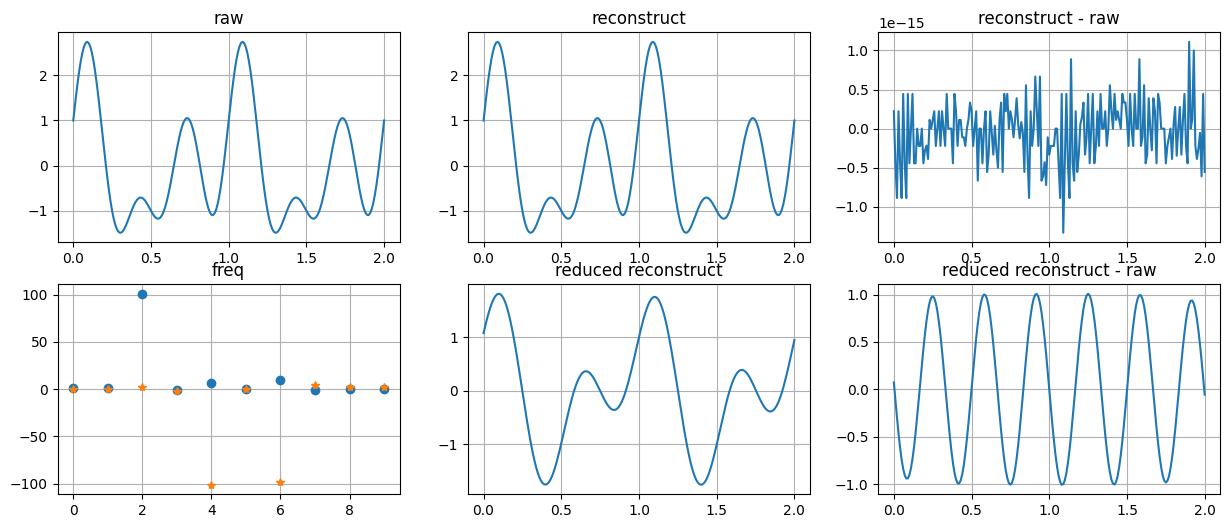

In [90]:
# fig,ax = plt.subplots(2,3)
# fig.set_figheight(6)
# fig.set_figwidth(15)


# x = np.arange(201)  / 100
# olr_re = np.sin(x * 2 * np.pi + 0.5*np.pi) + np.sin(x * 4 * np.pi) + np.sin(x * 6 * np.pi)
# ax[0,0].plot(x, olr_re)
# ax[0,0].grid(visible=True)
# ax[0,0].set_title('raw')

# coef_fft = np.fft.rfft(olr_re)
# olr_re_fft = np.fft.irfft(coef_fft, len(olr_re))
# ax[0,1].plot(x, olr_re_fft)
# ax[0,1].grid(visible=True)
# ax[0,1].set_title('reconstruct')

# ax[0,2].plot(x, olr_re_fft-olr_re)
# ax[0,2].grid(visible=True)
# ax[0,2].set_title('reconstruct - raw')

# wnx = 4
# coef_fft = np.fft.rfft(olr_re, axis=0)
# ax[1,0].plot(coef_fft[:10].real,'o')
# ax[1,0].plot(coef_fft[:10].imag,'*')
# ax[1,0].grid(visible=True)
# ax[1,0].set_title('freq')

# coef_fft[wnx+1:] = 0.0 
# # coef_fft[0] = 0.0 
# olr_re_fft = np.fft.irfft(coef_fft, len(olr_re), axis=0)
# ax[1,1].plot(x, olr_re_fft)
# ax[1,1].grid(visible=True)
# ax[1,1].set_title('reduced reconstruct')

# ax[1,2].plot(x, olr_re_fft-olr_re)
# ax[1,2].grid(visible=True)
# ax[1,2].set_title('reduced reconstruct - raw')